In [ ]:
#binary classification

## Dependencies

In [43]:
#pytorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, utils, datasets
import torch.functional as f
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm, tqdm_notebook

## Data Path and GPU

In [2]:
path='D:/Data Sets/Dental Disease/'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using=>',device)

Using=> cuda


In [4]:
#the dataset is for multi classification, from that we have converted it to a binary one :)
folders=os.listdir(path)
#print(folders)
folders.pop(folders.index('MorphologicalOperations.m'))
#print(folders)
x,y=[],[]
for i in tqdm(range(len(folders))):
    image_path=path+folders[i]+'/'
    images=os.listdir(image_path)
    #print(images)
    for image in images:
        img=plt.imread(image_path+image)
        x.append(img)
        y.append(folders[i].split()[0])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


In [5]:
print(len(x))
print(len(y))

284
284


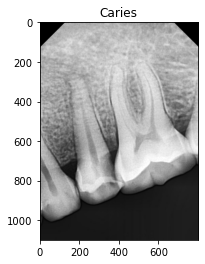

In [6]:
plt.title('Caries')
plt.imshow(x[13])
plt.show()
#x[1].shape

## Visualising class distribution

C:\Users\91884\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


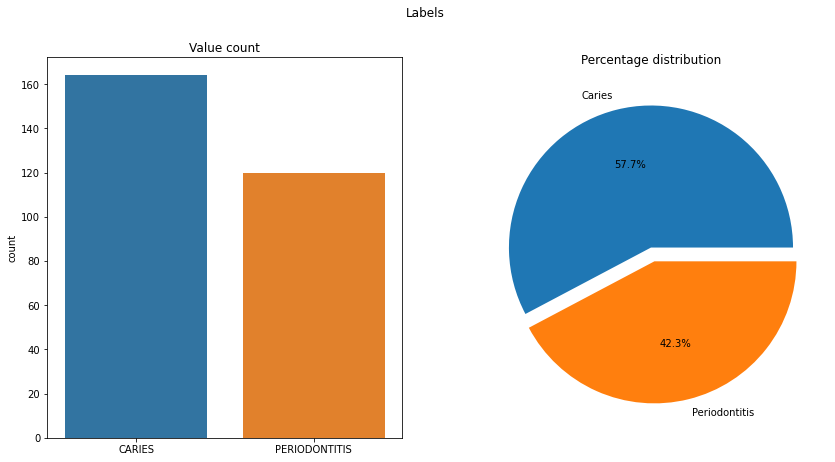

In [7]:
import seaborn as sns

f,ax=plt.subplots(1,2,figsize=(14,7))
f.suptitle('Labels')
sns.countplot(y,ax=ax[0])
values=[y.count('CARIES'),y.count('PERIODONTITIS')]
plt.pie(values,labels=['Caries','Periodontitis'],explode=[0,0.1],autopct='%1.1f%%')
ax[0].set_title('Value count')
ax[1].set_title('Percentage distribution')
plt.show()

In [8]:
#encoding target values
le=LabelEncoder()
y=np.array(le.fit_transform(y))

In [9]:
print(type(y))

<class 'numpy.ndarray'>


In [10]:
#now converting x to nd array
x=np.array(x)
type(x)

numpy.ndarray

In [11]:
x[13]

array([[[255, 255, 255],
        [249, 249, 249],
        [  3,   3,   3],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [ 36,  36,  36],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  1,   1,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 24,  24,  24],
        [ 24,  24,  24],
        [ 24,  24,  24],
        ...,
        [ 49,  49,  49],
        [ 54,  54,  54],
        [ 45,  45,  45]],

       [[ 24,  24,  24],
        [ 24,  24,  24],
        [ 24,  24,  24],
        ...,
        [ 53,  53,  53],
        [ 49,  49,  49],
        [ 32,  32,  32]],

       [[ 24,  24,  24],
        [ 24,  24,  24],
        [ 24,  24,  24],
        ...,
        [ 51,  51,  51],
        [ 38,  38,  38],
        [ 12,  12,  12]]

## Defining transform

In [12]:
image_transforms = {
    "train": transforms.Compose([#transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

In [13]:
#shuffling x and y
from sklearn.utils import shuffle
x,y=shuffle(x,y)
print(x,y)

[array([[[255, 255, 255],
        [249, 249, 249],
        [  3,   3,   3],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [ 36,  36,  36],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  1,   1,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[145, 145, 145],
        [146, 146, 146],
        [145, 145, 145],
        ...,
        [ 51,  51,  51],
        [ 58,  58,  58],
        [ 56,  56,  56]],

       [[150, 150, 150],
        [150, 150, 150],
        [150, 150, 150],
        ...,
        [ 55,  55,  55],
        [ 57,  57,  57],
        [ 40,  40,  40]],

       [[154, 154, 154],
        [155, 155, 155],
        [155, 155, 155],
        ...,
        [ 53,  53,  53],
        [ 47,  47,  47],
        [ 14,  14,  14]

## Train Test Split

In [14]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(227,)
(227,)
(57,)
(57,)


## Making a binary classification folder

In [15]:
#trainset

import matplotlib.image as mpimg

#img = mpimg.imread("src.png")
#mpimg.imsave("out.png", img)
p,c=0,0

for i in tqdm(range(227)):
    if y_train[i]==0:
        if not os.path.exists(path+'Binary Classification/train/Caries'):
            os.mkdir(path+'Binary Classification/train/Caries')
        c+=1
        mpimg.imsave(f'{path}Binary Classification/train/Caries/{c}.jpg',x_train[i])
    if y_train[i]==1:
        if not os.path.exists(path+'Binary Classification/train/Periodontitis'):
            os.mkdir(path+'Binary Classification/train/Periodontitis')
        p+=1
        mpimg.imsave(f'{path}Binary Classification/train/Periodontitis/{p}.jpg',x_train[i])

100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [00:10<00:00, 21.93it/s]


In [16]:
root_dir=path+'Binary Classification/'

In [17]:
trainset=datasets.ImageFolder(root = root_dir + "train",
                                      transform = image_transforms["train"]
                                     )

In [18]:
trainset

Dataset ImageFolder
    Number of datapoints: 227
    Root location: D:/Data Sets/Dental Disease/Binary Classification/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [19]:
trainset.class_to_idx

{'Caries': 0, 'Periodontitis': 1}

In [20]:
#testset
p,c=0,0

for i in tqdm(range(x_test.shape[0])):
    if y_test[i]==0:
        if not os.path.exists(path+'Binary Classification/test/Caries'):
            os.mkdir(path+'Binary Classification/test/Caries')
        c+=1
        mpimg.imsave(f'{path}Binary Classification/test/Caries/{c}.jpg',x_test[i])
    if y_test[i]==1:
        if not os.path.exists(path+'Binary Classification/test/Periodontitis'):
            os.mkdir(path+'Binary Classification/test/Periodontitis')
        p+=1
        mpimg.imsave(f'{path}Binary Classification/test/Periodontitis/{p}.jpg',x_test[i])

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:02<00:00, 19.10it/s]


In [21]:
testset=datasets.ImageFolder(root = root_dir + "test",
                                      transform = image_transforms["test"]
                                     )

In [22]:
testset.class_to_idx

{'Caries': 0, 'Periodontitis': 1}

In [23]:
train_loader = DataLoader(dataset=trainset, shuffle=True, batch_size=16)
test_loader = DataLoader(dataset=testset, shuffle=True, batch_size=1)

In [24]:
batch=next(iter(train_loader))

In [25]:
batch[0].shape #shape is in the format: (batch_size,channels,height,width)

torch.Size([16, 3, 224, 224])

In [26]:
print(batch[1]) #these are the labels 
print(batch[1].shape)

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1])
torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


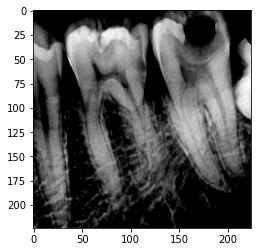

In [27]:
val=shuffle(range(16))[0]
image=batch[0][val]
print(image.shape)
plt.imshow(image.permute(1, 2, 0))
#plt expects in the format of (height,width, channel)
#but the image is in (c,h,w) so we will permute it to desired order

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


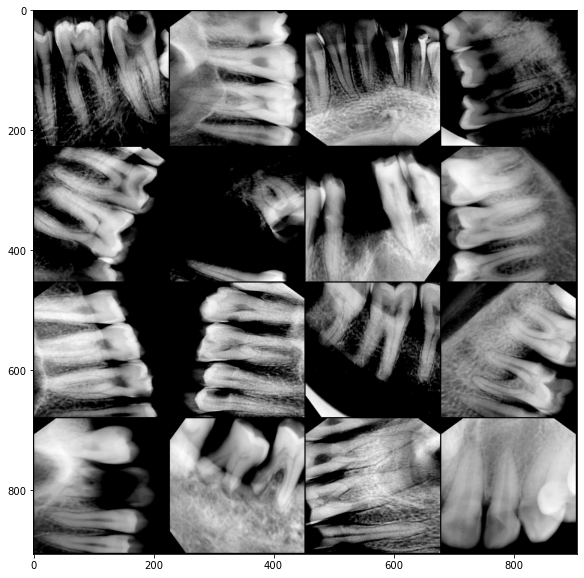

In [28]:
batch_grid=utils.make_grid(batch[0],nrow=4) #batch[0] is the first batch
plt.figure(figsize=(14,10))
plt.imshow(batch_grid.permute(1,2,0)) #plotting all the images of the first batch

## CNN Architecture

In [29]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        
        self.block1 = self.conv_block(c_in=3, c_out=64, kernel_size=3, stride=1, padding=1)
        self.block2 = self.conv_block(c_in=64, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block4 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block5 = self.conv_block(c_in=256, c_out=128, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=128, out_channels=2, kernel_size=28, stride=1, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
        x = self.maxpool(x)
    
        x = self.block3(x)
        x = self.block4(x)
        x = self.maxpool(x)
        
        x = self.block5(x)
        x = self.lastcnn(x)
        
        return x
    
    
    def conv_block(self, c_in, c_out, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
        )
        
        return seq_block        

In [31]:
model = Classifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Classifier(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.

In [32]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [33]:
accuracy_stats = {
    'train': []
}

loss_stats = {
    'train': []
}

In [34]:
print("Begin training.")

for e in tqdm(range(1, 11)):
    
    # TRAINING
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))                          
    
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}')

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Begin training.


 10%|████████▎                                                                          | 1/10 [00:18<02:50, 18.91s/it]

Epoch 01: | Train Loss: 1.41756 | Train Acc: 53.333


 20%|████████████████▌                                                                  | 2/10 [00:28<02:08, 16.11s/it]

Epoch 02: | Train Loss: 0.66919 | Train Acc: 65.800


 30%|████████████████████████▉                                                          | 3/10 [00:37<01:38, 14.07s/it]

Epoch 03: | Train Loss: 0.57126 | Train Acc: 71.600


 40%|█████████████████████████████████▏                                                 | 4/10 [00:46<01:15, 12.56s/it]

Epoch 04: | Train Loss: 0.39043 | Train Acc: 82.533


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:55<00:57, 11.52s/it]

Epoch 05: | Train Loss: 0.42798 | Train Acc: 77.667


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:05<00:43, 10.82s/it]

Epoch 06: | Train Loss: 0.47292 | Train Acc: 77.667


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:14<00:30, 10.27s/it]

Epoch 07: | Train Loss: 0.40384 | Train Acc: 83.000


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:23<00:19,  9.89s/it]

Epoch 08: | Train Loss: 0.60678 | Train Acc: 80.667


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:32<00:09,  9.78s/it]

Epoch 09: | Train Loss: 0.46454 | Train Acc: 79.067


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.17s/it]

Epoch 10: | Train Loss: 0.35795 | Train Acc: 85.467


Text(0.5, 1.0, 'Train Loss/Epoch')

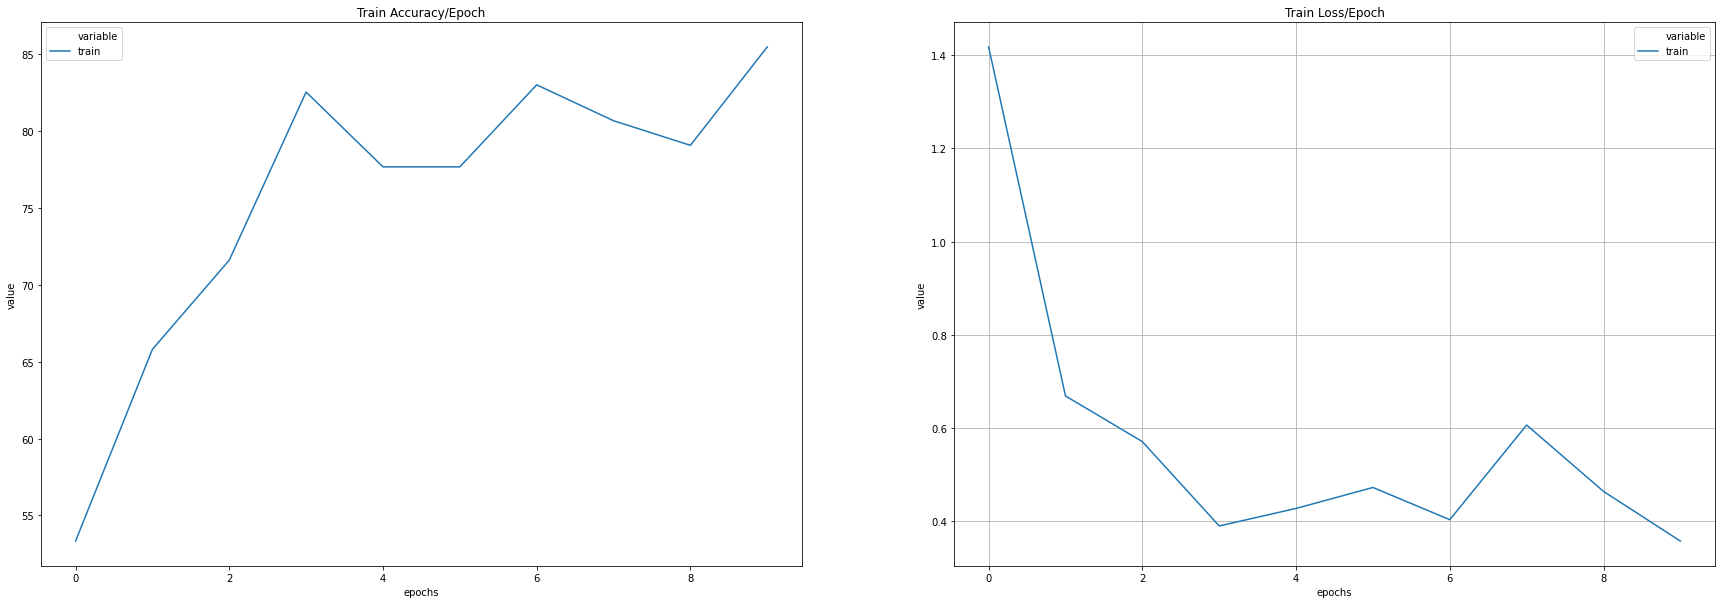

In [38]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train Accuracy/Epoch')
plt.grid()
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train Loss/Epoch')
#plt.grid()

In [39]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:04<00:00, 12.16it/s]


In [40]:
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [41]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        32
           1       0.36      0.36      0.36        25

    accuracy                           0.44        57
   macro avg       0.43      0.43      0.43        57
weighted avg       0.44      0.44      0.44        57

